In [1]:
from configs.default import _C as config
from configs.default import update_config

from datasets import flickr8k_parse
from nltk.translate.bleu_score import corpus_bleu
from scipy import misc

from models import decoder, image_preprocessing, predict, transfer_models

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import path_generation
import text_processing

from PIL import Image

import scipy as sc

Using TensorFlow backend.


In [2]:
config_file = "./configs/attn.yaml"
update_config(config, config_file) # config is imported from default.py _C above
# most parameters are in default.py, parameters in attn.yaml overwrite these defaults

# Evaluation for models built on Flickr8k

In [3]:
train_vocab = text_processing.Vocabulary()
word_to_id_path = os.path.join(config.PATH.VOCABULARY_PATH, config.VOCABULARY.WORD_TO_ID)
id_to_word_path = os.path.join(config.PATH.VOCABULARY_PATH, config.VOCABULARY.ID_TO_WORD)
count_path = os.path.join(config.PATH.VOCABULARY_PATH, config.VOCABULARY.COUNT)
train_vocab.load_vocabulary(word_to_id_path, id_to_word_path, count_path)

In [4]:
path_gen = path_generation.PathGenerator(config.DECODER.GRU, 
                                         config.DATASET, 
                                         config.DECODER.NUM_RNN_LAYERS, 
                                         config.DECODER.BATCH_SIZE, 
                                         config.DECODER.BATCH_NORM, 
                                         config.DECODER.DROPOUT, 
                                         config.ATTENTION, 
                                         config.DECODER.ATTN_TYPE)

path_checkpoint = path_gen.get_weights_path()
model_path = path_gen.get_model_path()
captions_path = path_gen.get_captions_path()
print("path_checkpoint",path_checkpoint,"\n model_path",model_path, \
     " \n captions_path",captions_path)

path_checkpoint ./model_files/weights/VGG16_LSTM_Flickr8k_2l_32b_bn_dr_attn_bahdanau.hdf5 
 model_path ./model_files/models/VGG16_LSTM_2l_bn_dr_attn_bahdanau.json  
 captions_path ./model_files/captions/VGG16_LSTM_Flickr8k_2l_32b_bn_dr_attn_bahdanau_3b.txt


In [5]:
if config.ATTENTION:
    transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_train_attn.npy'))
    val_transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_val_attn.npy'))
else:
    transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_train.npy'))
    val_transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_val.npy'))

In [6]:
decoder_model = decoder.load_model(model_path, path_checkpoint)

model_path ./model_files/models/VGG16_LSTM_2l_bn_dr_attn_bahdanau.json 
 weights_path ./model_files/weights/VGG16_LSTM_Flickr8k_2l_32b_bn_dr_attn_bahdanau.hdf5 





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








In [7]:
VGG_transfer_model, VGG_image_size = transfer_models.vgg_model(config.ATTENTION)
# VGG_transfer_model2, VGG_image_size2 = transfer_models.vgg_model2(config.ATTENTION)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________

i00 0 path0 ./datasets/MyImages/racecars/racecar_0.jpg
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
TV.shape (1, 512)
i00 1 path0 ./datasets/MyImages/racecars/racecar_1.jpg
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
TV.shape (1, 512)
i00 2 path0 ./datasets/MyImages/racecars/racecar_2.jpg
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
TV.shape (1, 512)
i00 3 path0 ./datasets/MyImages/racecars/racecar_3.jpg
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
TV.shape (1, 512)
i00 4 path0 ./datasets/MyImages/racecars/racecar_4.jpg
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
TV.shape (1, 512)
i00 5 path0 ./datasets/MyImages/racecars/racecar_5.jpg
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
TV.shape (1, 512)
i00 6 path0 ./datasets/MyImages/racecars/racecar_6.jpg
output_transfer_values.shape (1, 512)
output_transf

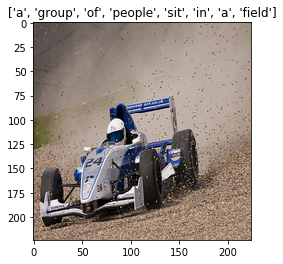

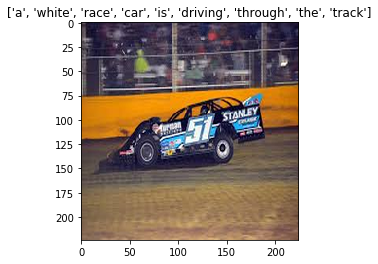

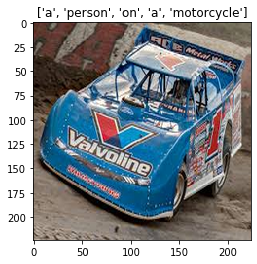

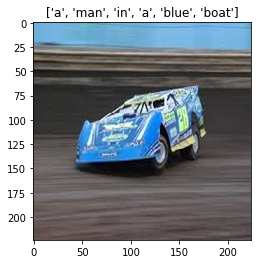

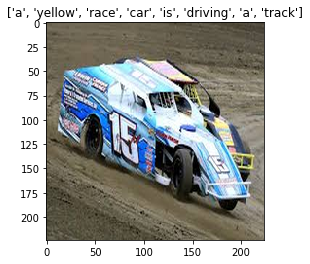

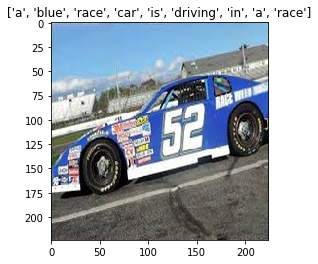

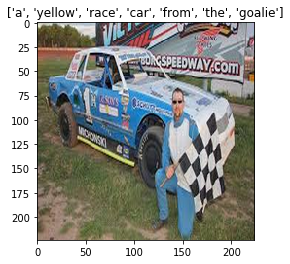

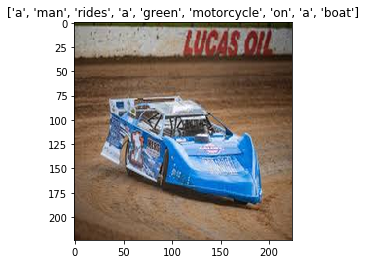

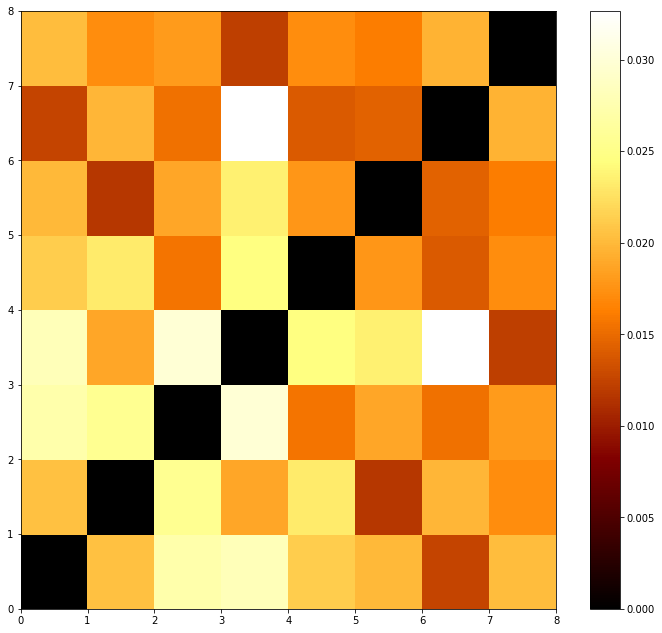

output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)


In [8]:
### beam size might be changed here
beam_size = 3
if config.ATTENTION:
    get_weights = True
else:
    get_weights = False

# captions file - all images
# captions_file = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr8k.token.txt")
# test image names
# test_txt_path = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr_8k.testImages.txt")
# 
# filenames_with_all_captions = \ 
# flickr8k_parse.generate_filenames_with_all_captions(captions_file,config.PATH.IMG_PATH)
# test filenames with all captions
# test_filenames_with_all_captions = \
# flickr8k_parse.generate_set(test_txt_path,filenames_with_all_captions,config.PATH.IMG_PATH)

# file1="./datasets/MyImages/security/assault_files.txt"
file1="./datasets/MyImages/racecar_files.txt"
# file1="./datasets/Flickr8k/annotations/Flickr_8k.testImages.txt"
# file1="./datasets/MyImages/brown_dog_files.txt"

# file1 is a txt file with the names of test jpg files to be processed
with open (file1, "r") as test_files:
    t_files=test_files.read().splitlines()

n_images=8
n_start=0
TVa=np.zeros((n_images,512))
distance=np.zeros((n_images,n_images))
for i00 in range (n_start,n_start+n_images):
    i01=i00-n_start
    path0=t_files[i00] # t_files are the names of the test files (jpg)
#    path0='./datasets/Flickr8k/Images/' + path0
    path0='./datasets/MyImages/racecars/' + path0
    print("i00",i00,"path0",path0)
    result0, probs0, weights0, TV = predict.generate_caption(path0,VGG_image_size,decoder_model, \
                                       VGG_transfer_model, \
                                       train_vocab,beam_size=beam_size, \
                                       attn=config.ATTENTION,get_weights=get_weights)
    print("TV.shape",TV.shape)
    TVa[i01,:]=TV[0]
    plt.figure(i00)
    plt.title(result0[0])
    img = image_preprocessing.image_preprocessing(path0, VGG_image_size)
    plt.imshow(img)
    picout='./datasets/MyImages/racecars/' + 'assault_labelled' + str(i00)
    plt.savefig(picout)
#    plt.show()
    
for i00 in range(n_images):
    for j00 in range(n_images):
        distance[i00,j00]=sc.spatial.distance.cosine(TVa[i00],TVa[j00])
        
print('distance',distance)
plt.figure(42,figsize=(12,11))
plt.pcolormesh(distance,cmap='afmhot')
plt.colorbar()
plt.show(42)
    
path0 = './datasets/Flickr8k/Images/240696675_7d05193aa0.jpg'
path1 = './datasets/Flickr8k/Images/2994179598_a45c2732b5.jpg'


# some testing code
#
# x0=image_preprocessing.image_preprocessing(path0,VGG_image_size)
# y0 = np.expand_dims(x0, axis=0)
# z0 = VGG_transfer_model.predict(y0)
# x1=image_preprocessing.image_preprocessing(path,VGG_image_size)
# y1 = np.expand_dims(x1, axis=0)
# z1 = VGG_transfer_model.predict(y1)

# for i in range (4096):
#     print("i",i,"z0[0,i]",z0[0,i],"z1[0,i]",z1[0,i])

result0 = predict.generate_caption(path0, 
                                  VGG_image_size, 
                                  decoder_model, 
                                  VGG_transfer_model, 
                                  train_vocab, 
                                  beam_size=beam_size, 
                                  attn=config.ATTENTION, 
                                  get_weights=get_weights)
result1 = predict.generate_caption(path1, 
                                  VGG_image_size, 
                                  decoder_model, 
                                  VGG_transfer_model, 
                                  train_vocab, 
                                  beam_size=beam_size, 
                                  attn=config.ATTENTION, 
                                  get_weights=get_weights)


In [9]:
if get_weights:
    captions, probs, weights, tf0 = result1
else:
    captions, probs, tf0 = result1
best_caption = captions[0]

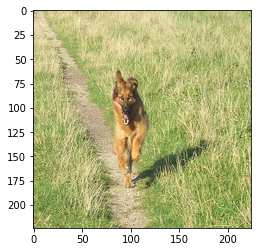

result0 [['a', 'black', 'dog', 'runs', 'through', 'the', 'grass'], ['a', 'black', 'dog', 'running', 'through', 'the', 'grass'], ['a', 'black', 'dog', 'runs', 'through', 'a', 'field']]


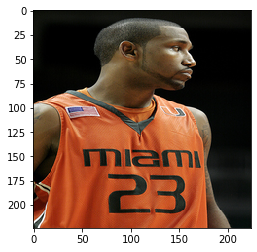

result1 [['a', 'young', 'boy', 'wearing', 'a', 'blue', 'shirt', 'is', 'playing', 'a', 'game'], ['a', 'young', 'boy', 'wearing', 'a', 'blue', 'shirt', 'is', 'playing', 'the', 'game'], ['a', 'young', 'boy', 'wearing', 'a', 'blue', 'shirt', 'is', 'playing', 'a', 'game', 'of', 'a', 'man', 'in', 'a', 'red', 'shirt']]
a young boy wearing a blue shirt is playing a game -0.861
a young boy wearing a blue shirt is playing the game -0.900
a young boy wearing a blue shirt is playing a game of a man in a red shirt -1.424


In [10]:
img = image_preprocessing.image_preprocessing(path0, VGG_image_size)
plt.imshow(img)
plt.show()
print('result0',result0[0])
img = image_preprocessing.image_preprocessing(path1, VGG_image_size)
plt.imshow(img)
plt.show()
print('result1',result1[0])
for i in range(len(captions)):
    print(" ".join(captions[i]),
          "{:.3f}".format(probs[i]))

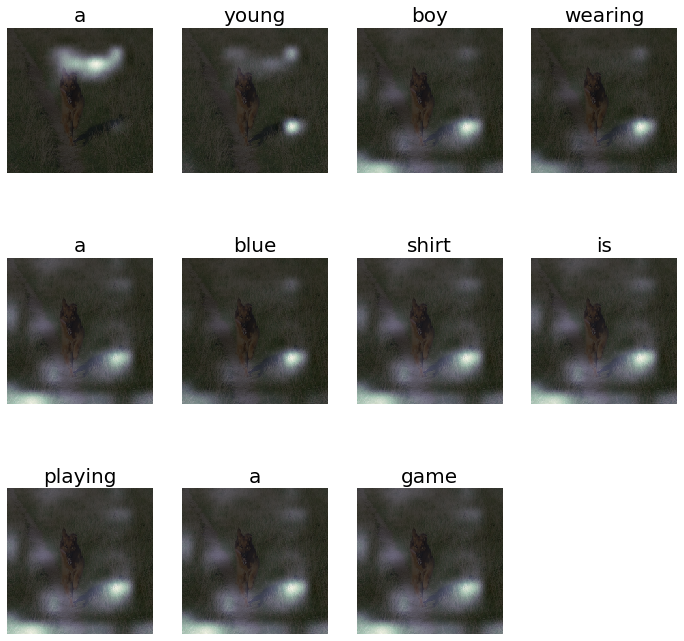

In [11]:
if get_weights:
    cols = 4
    rows = math.ceil(len(best_caption) / cols)
    plt.figure(1, figsize=(12,12))
    for word_num in range(len(best_caption)):
        weights_img = np.reshape(weights[word_num], [14,14])
#        weights_img = misc.imresize(weights_img, (224, 224))
        weights_img = np.array(Image.fromarray(weights_img).resize((224,224)))
        img = image_preprocessing.image_preprocessing(path0, (224,224))
        plt.subplot(rows, cols, word_num + 1)
        plt.title(best_caption[word_num], fontsize=20)
        plt.imshow(img)
        plt.imshow(weights_img, cmap='bone', alpha=0.8)
        plt.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.savefig('./test.png')
    plt.show()

In [12]:
captions_file = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr8k.token.txt")
test_txt_path = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr_8k.testImages.txt")

filenames_with_all_captions = flickr8k_parse.generate_filenames_with_all_captions(captions_file, config.PATH.IMG_PATH)

test_filenames_with_all_captions = flickr8k_parse.generate_set(test_txt_path, 
                                                               filenames_with_all_captions, 
                                                               config.PATH.IMG_PATH)
# print("test_filenames_with_all_captions",test_filenames_with_all_captions)
test_captions = flickr8k_parse.make_list_of_captions(test_filenames_with_all_captions)

In [13]:
text_processing.preprocess_captions(test_captions)

In [14]:
references = []
for list_captions in test_captions:
    reference = []
    for caption in list_captions:
        reference.append(caption.split())
    references.append(reference)

In [15]:
references[0]

[['the',
  'dogs',
  'are',
  'in',
  'the',
  'snow',
  'in',
  'front',
  'of',
  'a',
  'fence'],
 ['the', 'dogs', 'play', 'on', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'wrestle', 'in', 'the', 'snow'],
 ['two', 'dogs', 'playing', 'in', 'the', 'snow']]

In [16]:
if config.ATTENTION:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_test_attn.npy')
else:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_test.npy')
    
print("transfer_values.shape",transfer_values.shape)

transfer_values.shape (1000, 14, 14, 512)


In [17]:
use_transfer_values = True
generated_captions = predict.generate_test_captions(transfer_values, 
                                                    VGG_image_size, 
                                                    decoder_model, 
                                                    VGG_transfer_model, 
                                                    train_vocab, 
                                                    use_transfer_values, 
                                                    beam_size,
                                                    config.DECODER.MAX_LEN,
                                                    config.ATTENTION, 
                                                    False)
print("generated_captions",generated_captions)

output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_trans

output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_trans

output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_trans

output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_trans

output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_transfer_values.shape (1, 512)
output_trans

In [18]:
print("captions_path",captions_path)
with open(captions_path, 'w') as captions_file:
    for caption in generated_captions:
        captions_file.write(" ".join(caption))
        captions_file.write("\n")

captions_path ./model_files/captions/VGG16_LSTM_Flickr8k_2l_32b_bn_dr_attn_bahdanau_3b.txt


In [19]:
# BLEU score often quoted as a zero to one scale. There is a factor of 100 in these
# expressions so I think that is why they are 0 to 100 here; even though the
# factor multiplies the weights - probably the same effect.
print('BLEU-1 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(1,0,0,0)) * 100))

BLEU-1 Score on test data: 53.987


In [20]:
print('BLEU-2 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.5,0.5)) * 100))

BLEU-2 Score on test data: 34.507


In [21]:
print('BLEU-3 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.33,0.33,0.33,0)) * 100))

BLEU-3 Score on test data: 21.911


In [22]:
print('BLEU-4 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.25,0.25,0.25,0.25)) * 100))

BLEU-4 Score on test data: 13.534
